# Méthode semi-Lagrangienne généralisée

Cette méthode ne fait pas d'interpolation à chaque itération en temps, mais revient à la condition initiale sur la 
grille grâce aux caractéristiques.

Une amélioration possible est de procéder à une interpolation tous les $T$ itérations afin de ne pas avoir de soucis
dans la quadrature lorsque les caractéristiques tendent à converger vers une zone restreinte du domaine d'étude.

In [1]:
using LinearAlgebra, QuadGK, Roots, FFTW
using VlasovSolvers
using Plots

import VlasovSolvers: advection!
import VlasovSolvers: samples, Particles, PIC_step!, compute_rho
using ProgressMeter

using LaTeXStrings

In [2]:
struct rkn_order4
    a :: Array{Float64}
    b̄ :: Array{Float64}
    c :: Array{Float64}
    b :: Array{Float64}
    fg :: Array{Float64}
    tmpX :: Array{Float64}
    tmpcos :: Array{Float64}
    tmpsin :: Array{Float64}

    function rkn_order4(X)
        a = [0.0        0.0       0.0; 
            (2-√3)/12   0.0           0.0; 
            0.0         √(3)/6      0.0]
        b̄ = [(5 - 3*√3) / 24,   (3+√3)/12,   (1+√3)/24]
        c = [(3+√3)/6,          (3-√3)/6,   (3+√3)/6]
        b = [(3-2*√3)/12,       1/2,        (3+2*√3)/12]
        
        # 3 because RKN_order4 is a 3-stage method.
        fg = Array{Float64}(undef, 3, size(X)...)
        tmpX = similar(X)
        tmpcos = similar(X)
        tmpsin = similar(X)

        new(a, b̄, c, b, fg, tmpX, tmpcos, tmpsin)
    end
end

In [26]:
#= ====================
Advance (X, V) on a time step dt using symplectic Runge-Kutta-Nystrom method of order4 [FQ10, sect.7.3, p.327, scheme1].

The equation satisfied by X is d^2(X(t)) / dt^2 = C(t)\cos(X(t)) - S(t)sin(X(t)).

RKN method considers Ẋ = V as a variable, and updates both X and V.

Using a change of variable and the jacobian of the flow being equal to 1, it is enough to know the function f on some
initial fixed grid, independant of time, to compute C(t) and S(t).

Args:
- X: matrix of positions at time t_n
- V: matrix of velocities at time t_n
- F: values of initial condition at time t_0
- dt: time step

Updates X, V in place so that when the function returns :
- X: matrix of positions at time t_{n+1}
- V: matrix of velocities at time t_{n+1}
==================== =#
function symplectic_RKN_order4!(X, V, F, rkn, kx, dt, dxdv)  
    for s=1:3
        rkn.tmpX .= X .+ dt .* rkn.c[s] .* V .+ dt^2 .* sum(rkn.a[s, :] .* rkn.fg, dims=1)[1, :, :]
        rkn.tmpcos .= cos.(rkn.tmpX .* kx)
        rkn.tmpsin .= sin.(rkn.tmpX .* kx)
        C = sum(rkn.tmpcos .* F) * dxdv
        S = sum(rkn.tmpsin .* F) * dxdv
        rkn.fg[s, :, :] .= (C .* rkn.tmpsin .- S .* rkn.tmpcos) ./ π
    end
    
    X .+= dt .* V.+ dt^2 .* sum(rkn.b̄ .* rkn.fg, dims=1)[1, :, :]
    V .+= dt .* sum(rkn.b .* rkn.fg, dims=1)[1, :, :]
    rkn.tmpcos .= cos.(X .* kx)
    rkn.tmpsin .= sin.(X .* kx)
    C = sum(rkn.tmpcos .* F) * dxdv
    S = sum(rkn.tmpsin .* F) * dxdv
    return C, S
end

symplectic_RKN_order4! (generic function with 1 method)

## SL Généralisée

In [27]:
function generalized_SL(nsteps::Int64, dt::Float64, meshx::OneDGrid, meshv::OneDGrid, f0::Function; plotting=false::Bool)

    x0 = Array(meshx.points)
    v0 = Array(meshv.points)

    newX = repeat(x0, 1, nv)   # newX[i, j] is position at current time when starting from x0_i, v0_j
    newV = repeat(v0', nx, 1)  # newV[i, j] is velocity at current time when starting from x0_i, v0_j
    
    E2_elec  = Array{Float64}(undef, nsteps)
    E_tot   = Array{Float64}(undef, nsteps)
    dphidx  = similar(newX)

    rkn = rkn_order4(newX)
    
    widthx = meshx.stop - meshx.start
    widthv = meshv.stop - meshv.start
        
    progression = ProgressMeter.Progress(nstep,desc="Loop in time: ", showspeed=true)
    
    f0vals = f0.(x0, v0')

    dxdv = meshx.step * meshv.step
    
    animation = @animate for istep=1:nsteps
        C, S = symplectic_RKN_order4!(newX, newV, f0vals, rkn, kx, dt, dxdv)
        
        dphidx   .= (-C.*rkn.tmpsin .+ S.*rkn.tmpcos) ./ π
        E2_elec[istep] = (C^2 + S^2) / (kx*π)
        E_tot[istep] = sqrt(E2_elec[istep] + sum(newV.^2 .* f0vals) .* dxdv) / √2 
        
        
        newX[findall(newX .> meshx.stop)] .-= meshx.stop - meshx.start
        newX[findall(newX .< meshx.start )] .+= meshx.stop - meshx.start
 
        if plotting
            # histogram2d(vec(newX), vec(newV), weights=vec(f0vals), bins=(nx, nv).*3, normalize=true, xlabel="position", ylabel="velocity", fillcolor=:roma)
            scale = 25
            plot(vec(newX), vec(newV), vec(f0vals), seriestype=:scatter, markersize=sqrt(widthx * widthv * scale^2  / (nx*nv) / π), camera=(0, 90),markerstrokecolor="white", markerstrokewidth=0, label="", zcolor=vec(f0vals), c=:rainbow,aspect_ratio=:equal, size=(widthx, widthv).*scale)
            title!("Progression: $(round(Int64,100*progression.counter / progression.n))%")
        end
        ProgressMeter.next!(progression)
     end when plotting

     return sqrt.(E2_elec), E_tot, animation, newX, newV, f0vals
end

generalized_SL (generic function with 1 method)

## SL classique

In [5]:
"""
    hmf_poisson!(fᵗ    :: Array{Complex{Float64},2},
                 mesh1 :: OneDGrid,
                 mesh2 :: OneDGrid,
                 ex    :: Array{Float64})

    Compute the electric hamiltonian mean field from the
    transposed distribution function

"""
function hmf_poisson!(fᵗ::Array{Complex{Float64},2},
        mesh1::OneDGrid,
        mesh2::OneDGrid,
        ex::Array{Float64})

    n1 = mesh1.len
    rho = mesh2.step .* vec(sum(fᵗ, dims=1)) # ≈ ∫ f(t,x_i,v)dv, i=1, ..., n1
    rho .-= sum(rho) * mesh1.step / mesh1.stop
    kernel = zeros(Float64, n1)
    k = -(mesh1.stop - mesh1.start) / (2π)
    kernel[2]   =  k    # fourier mode  1
    kernel[end] = -k    # fourier mode -1
    ex .= real(ifft(fft(rho) .* 1im .* kernel))
end


function solve_SL!(nsteps, dt, f, mesh1, mesh2; plotting=false::Bool)
    n1, n2 = size(f)
    fᵗ = zeros(Complex{Float64}, (n2,n1))
    transpose!(fᵗ, f)

    energy = Array{Float64}(undef, nsteps)

    ex = zeros(Float64, n1)
    hmf_poisson!(fᵗ, mesh1, mesh2, ex)
    advection!(fᵗ, mesh2, ex, 0.5dt)

    progression = ProgressMeter.Progress(nsteps,desc="Loop in time: ", showspeed=true)
    
    animation = @animate for istep = 1:nsteps
        energy[istep] = sqrt(sum(ex.^2) * mesh1.step)
        # etot[istep] = sqrt(energy[istep]^2 + sum()*mesh1.step*mesh2.step)
    
        if plotting
            plot(mesh1.points, mesh2.points, real(f)', size=(500, 500), st=:surface, camera=(0, 90))
            title!("Progression: $(round(Int64,100*progression.counter / progression.n))%")
        end
        advection!(f, mesh1, mesh2.points, dt)
        transpose!(fᵗ, f)
        hmf_poisson!(fᵗ, mesh1, mesh2, ex)
        advection!(fᵗ, mesh2, ex, dt)
        transpose!(f, fᵗ) 
        ProgressMeter.next!(progression)
    end when plotting
    if plotting
        return energy, ex, animation
    else
        return energy, ex, nothing
    end
end

solve_SL! (generic function with 1 method)

# INPUTS

## Landau damping

In [6]:
kx = 0.5
L = 2π / kx
ϵ = 0.001
μ = 0.0
β = 1.0
f(x,v) = (1 + ϵ * cos(kx*x)) * exp(-β * (v-μ)^2 / 2) / √(2π/β)
castest = "Landau damping\n(kx, ϵ, μ, β) = $((kx, ϵ, μ, β)))"

"Landau damping\n(kx, ϵ, μ, β) = (0.5, 0.001, 0.0, 1.0))"

## Two-Stream Instability

### Première version

In [ ]:
kx = 0.2
L = 2π / kx
ϵ = 0.001
β₁ = 1
β₂ = 1
v0 = 2.4
μ₁ =  v0
μ₂ = -v0
f(x,v) = (1 + ϵ * cos(kx * x)) * (exp(-β₁*(v-μ₁)^2 / 2) + exp(-β₁*(v-μ₂)^2 / 2)) / (√(2π)) * 0.5
castest = "TSI\n(kx, β₁, β₂, μ₁, μ₂) = $((kx, β₁, β₂, μ₁, μ₂))"

### Seconde version

In [ ]:
kx = 0.2
L = 2π / kx
ϵ = 0.001
β = 1
μ =  0
f(x,v) = (1 + ϵ * cos(kx * x)) * v^2 * exp(-β*(v-μ)^2 / 2) / (√(2π))
castest = "TSI\n(kx, β, μ) = $((kx, β, μ))"

## Bump-on-Tail

In [ ]:
kx = 0.3
L = 2π / kx
ϵ = 0.04
β₁ = 1
β₂ = 1 / (0.5^2)
μ₁ = 0
μ₂ = 4.5
nb = 0.2
np = 0.9
f(x,v) = (1 + ϵ * cos(kx*x)) * (np*exp(-β₁*(v-μ₁)^2 /2) + nb*exp(-β₂*(v-μ₂)^2 / 2)) / √(2π)
castest = "Bump on tail\n(kx, ϵ, β₁, β₂, μ₁, μ₂, nb, np) = $((kx, ϵ, β₁, β₂, μ₁, μ₂, nb, np))"

## Strong Landau Damping

In [ ]:
kx = 0.5
L = 2π / kx
ϵ = 0.5
β = 1.0
μ = 0.0
f(x,v) = (1 + ϵ * cos(kx*x)) * exp(-β * v^2 / 2) / √(2π/β)
castest = "Strong Landau damping\n(kx, ϵ, μ, β) = $((kx, ϵ, μ, β)))"

# Inputs indépendants du cas test

In [68]:
dev = CPU()

nstep = 100
dt = 0.5

0.5

In [69]:
nx = 128
nv = 127

meshx = OneDGrid(dev, nx, 0, L)
meshv = OneDGrid(dev, nv, -10, 10);

# Simulations

In [76]:
gsl  = zeros(Complex{Float64}, (nx,nv))
@. gsl = f.(meshx.points, meshv.points');
@time E_elecsl, _, animationsl = solve_SL!(nstep, dt, gsl, meshx, meshv; plotting=false);

Loop in time: 100%|███████████████████████| Time: 0:00:00 ( 7.93 ms/it)


  0.797420 seconds (1.87 M allocations: 115.700 MiB, 2.20% gc time)


In [77]:
gsl  = zeros(Complex{Float64}, (nx,nv))
@. gsl = f.(meshx.points, meshv.points');
@time E_elecsl_2, _, animationsl = solve_SL!(1000, 0.05, gsl, meshx, meshv; plotting=false);

Loop in time: 100%|███████████████████████| Time: 0:00:07 ( 7.52 ms/it)


  7.528476 seconds (18.61 M allocations: 1.122 GiB, 2.27% gc time)


In [78]:
p = false
@time E_elec, E_tot, animation, X, V, F = generalized_SL(nstep, dt, meshx, meshv, f, plotting=p);
@time E_elec_2, E_tot_2, animation, X, V, F = generalized_SL(1000, 0.05, meshx, meshv, f, plotting=p);
# nstep=1000: 3.852896 seconds (558.21 k allocations: 4.159 GiB, 9.63% gc time)
# nstep=5000: 20.110145 seconds (1.76 M allocations: 20.773 GiB, 8.93% gc time)

Loop in time: 100%|███████████████████████| Time: 0:00:00 ( 4.26 ms/it)
Loop in time: 100%|███████████████████████| Time: 0:00:00 ( 4.25 ms/it)


  0.426651 seconds (290.58 k allocations: 436.476 MiB, 12.66% gc time)
  3.985705 seconds (555.80 k allocations: 4.151 GiB, 9.82% gc time)


In [79]:
if p
    gif(animation, "generalized_semilag.gif")
end

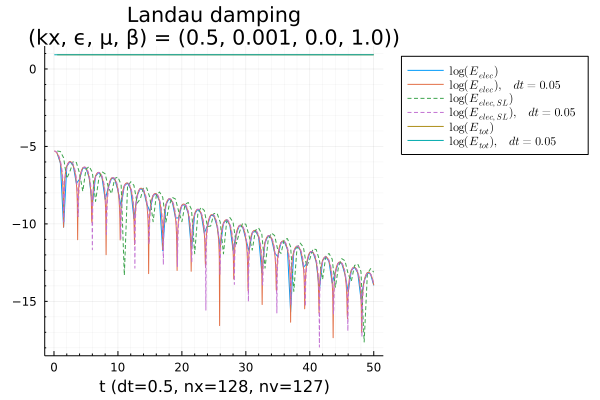

In [83]:
t = (1:nstep).*dt
t_2 = (1:1000).*0.05

# energies
# plot(t, E_elec.^2, label=L"E_{elec}^2", legend=:outertopright, minorgrid=true)
# plot!(t, E_tot, label=L"E_{tot}", scaley=:log10)

# log(Energies)
plot(t, log.(E_elec),       label=L"\log(E_{elec})", legend=:outertopright, minorgrid=true)
plot!(t_2, log.(E_elec_2),       label=L"\log(E_{elec}), \quad dt=0.05")
plot!(t, log.(E_elecsl),    label=L"\log(E_{elec, SL})", ls=:dash, lw=1)
plot!(t_2, log.(E_elecsl_2),    label=L"\log(E_{elec, SL}), \quad dt=0.05", ls=:dash, lw=1)
plot!(t, log.(E_tot),       label=L"\log(E_{tot})")
plot!(t_2, log.(E_tot_2),       label=L"\log(E_{tot}), \quad dt=0.05")

# plot(t, log.(E_elec) .- log(2),       label=L"\log(E_{elec})", legend=:outertopright, minorgrid=true)
# plot!(t, log.(E_elecsl) .- log(2),    label=L"\log(E_{elec, SL})", ls=:dot, lw=5)
# plot!(t, log.(E_tot),       label=L"\log(E_{tot})")


# ============== #

# Landau damping (kx=0.5):
# plot!(x->-0.1533x - 5.6, label="Damping attendu (-0.1533)")
# E_th = abs.(4ϵ * 0.3677 .* exp.(−0.1533 .* t) .* cos.(1.4156.*t .−0.5326245) .* sqrt(L/2))
# plot!(t, log.(E_th),label="Energie theorique", ls=:dash)
# Landau damping (kx=0.4):
# plot!(x->-0.0661x - 5.3, label="Damping attendu (-0.0661)")
# E_th = 0.002.*0.42466.*abs.(cos.(1.285.*t .-0.33577)).*exp.(-0.0661.*t) # expression du bouquin, pas correcte
# E_th = abs.(4*ϵ*0.424666*exp.(-0.0661 .* t) .* cos.(1.2850 .* t .- 0.3357725) * sqrt(L/2)) # issue des calculs du bouquin en calculant correctement √(∫sin(0.5x)^2dx)
# plot!(t, log.(E_th) .- log(2),label="Energie theorique", ls=:dash)

# TSI (k,v0) = (0.2, 1.3):
# plot!(t, -0.001t .- 4.2, label=L"y=0.001t - 5.0")
# TSI (k,v0) = (0.2, 2.4):
# plot!(t, 0.2258t .- 6.4, label=L"y=0.2258t - 8.4")
# TSI (k,v0) = (0.2, 3):
# plot!(t, 0.2845t .- 6.1, label=L"y=0.2845t - 8.2")

# Strong Landau damping
# plot!(t, -0.285473t .+ 1, label=L"y=-0.285473t + 1")
# plot!(t, 0.086671t .- 3.5, label=L"y=0.086671t - 3.5")

title!(castest)
xlabel!("t (dt=$(dt), nx=$(nx), nv=$(nv))")

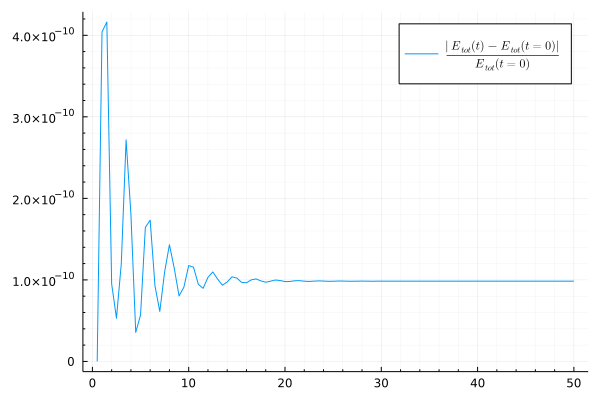

In [55]:
plot(t, abs.((E_tot .- E_tot[1])) ./ E_tot[1], label=L"\frac{|E_{tot}(t) - E_{tot}(t=0)|}{E_{tot}(t=0)}", minorgrid=true)
plot(t_2, abs.((E_tot_2 .- E_tot_2[1])) ./ E_tot_2[1], label=L"\frac{|E_{tot}(t) - E_{tot}(t=0)|}{E_{tot}(t=0)}, \quad dt=0.05")

intégrations points de gauss
schémas symplectiques ordres élevés

In [ ]:
@time E_elec, E_tot, animation, X, V, F = generalized_SL(nstep, dt, meshx, meshv, f, plotting=false);

plot(vec(X), vec(V), vec(F), seriestype=:scatter, markersize=sqrt(L *  / (nx*nv) / π), camera=(0, 90),markerstrokecolor="white", markerstrokewidth=0, label="", zcolor=vec(F), c=:rainbow,aspect_ratio=:equal, size=(L*25, 20*25))
